In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import save_image

In [14]:
if (os.path.exists("./data")) == False:
    os.mkdir("data")

In [15]:
dir_pokemon = "./archive/pokemon"
files_pokemon = os.listdir(dir_pokemon + '/pokemon')

In [16]:
transform=transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
batch_size = 400

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = ImageFolder(root = dir_pokemon, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last = True)

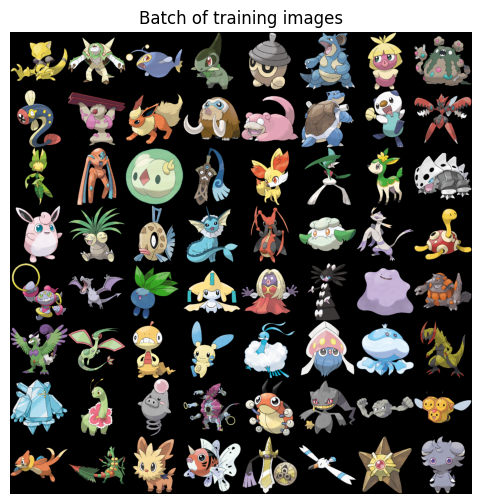

In [17]:
first_batch = next(iter(dataloader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Batch of training images")
plt.imshow(vutils.make_grid(first_batch[0][:64], padding=2, normalize=True).cpu().numpy().transpose(1,2,0))
plt.show()

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=0, bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

# Train

In [20]:
criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()


generator.to(device)
discriminator.to(device)

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 1000

In [21]:
# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        image, image_label = data[0].to(device), data[1].to(device)

        # Train discriminator
        discriminator.zero_grad()

        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)

        output = discriminator(image).view(-1)

        loss_discriminator_real = criterion(output, label)
        loss_discriminator_real.backward()

        noise = torch.randn(batch_size, 128, 1, 1, device=device)
        fake_image = generator(noise)
        label.fill_(0)

        output = discriminator(fake_image.detach()).view(-1)

        loss_discriminator_fake = criterion(output, label)
        loss_discriminator_fake.backward()

        errD = loss_discriminator_real + loss_discriminator_fake
        optimizerD.step()

        # Train generator
        generator.zero_grad()
        label.fill_(1)
        output = discriminator(fake_image).view(-1)

        loss_generator = criterion(output, label)
        loss_generator.backward()
        optimizerG.step()

    if (epoch % 10 == 0):
        with torch.no_grad():
            fixed_noise = torch.randn(64, 128, 1, 1, device=device)
            fake_images = generator(fixed_noise).detach().cpu()
            loss_on_real = loss_discriminator_real.detach().cpu()
            loss_on_fake = loss_discriminator_fake.detach().cpu()

        print(f'epoch: {epoch}, loss on real: {loss_on_real}, loss on fake: {loss_on_fake}')

        save_image(fake_images, f'./data/fake_images_epoch_{epoch:04d}.png', nrow=8, normalize=True)

epoch: 0, loss on real: 0.6504414081573486, loss on fake: 1.7245566844940186
epoch: 10, loss on real: 0.4064267575740814, loss on fake: 0.4291057884693146
epoch: 20, loss on real: 0.23290599882602692, loss on fake: 0.40900665521621704
epoch: 30, loss on real: 0.16936439275741577, loss on fake: 0.20912498235702515
epoch: 40, loss on real: 0.12486835569143295, loss on fake: 0.18463458120822906
epoch: 50, loss on real: 0.12280537933111191, loss on fake: 0.18433602154254913
epoch: 60, loss on real: 0.14562006294727325, loss on fake: 0.22730585932731628
epoch: 70, loss on real: 0.14535722136497498, loss on fake: 0.22032973170280457
epoch: 80, loss on real: 0.08643036335706711, loss on fake: 0.1811305582523346


KeyboardInterrupt: 